# 03. cosine distance 기반

In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

results_dir = Path('../data/results')
results_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# 프로젝트 루트를 Python 경로에 추가
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

from scripts.analysis.analyze import load_and_balance_data

# 데이터 로드 및 밸런싱
expanded_dir = Path('../data/processed/expanded')
df = load_and_balance_data(expanded_dir)

# 데이터 로드
print(f"Total posts: {len(df)}")


발견된 파일: 8개
  - expanded_dcinside_향수화장품_갤러리.csv: 17381행
  - expanded_dcinside_수능_갤러리.csv: 9327행
  - expanded_dcinside_해외축구_갤러리.csv: 5700행
  - expanded_dcinside_국내연예-남자여자연예인_갤러리.csv: 14430행
  - expanded_dcinside_남자연예인_갤러리.csv: 6844행
  - expanded_theqoo_beauty_category_25604.csv: 17199행
  - expanded_dcinside_리그오브레전드_갤러리.csv: 9075행
  - expanded_theqoo_ktalk_category_1947874.csv: 11361행

⚖️ 밸런싱 기준: 최소 5700행 (랜덤 샘플링)
✅ 병합 완료: 총 45600행 (커뮤니티당 5700행)
데이터 파싱 중 (종결 어미, 기호)...
Total posts: 45600


In [3]:
community_name_map = {
    'dcinside_수능_갤러리': '디시-수능',
    'dcinside_해외축구_갤러리': '디시-해외축구',
    'dcinside_리그오브레전드_갤러리': '디시-리그오브레전드',
    'dcinside_국내연예-남자여자연예인_갤러리': '디시-국내연예',
    'dcinside_남자연예인_갤러리': '디시-남자연예인',
    'dcinside_향수화장품_갤러리': '디시-향수·화장품',
    'theqoo_ktalk/category/1947874': '더쿠-케이돌토크',
    'theqoo_beauty/category/25604': '더쿠-뷰티'
}
df['community'] = df['community'].replace(community_name_map)

In [4]:
custom_order = [
    '디시-국내연예',
    '디시-남자연예인',
    '더쿠-케이돌토크',
    '더쿠-뷰티',
    '디시-향수·화장품',
    '디시-수능',
    '디시-리그오브레전드',
    '디시-해외축구',
]


## 1. 특성 벡터 생성

In [5]:
# 특성 정의
# 어미는 이미 데이터 전처리 단계에서 정규화됨
all_endings_flat = [item[0] for sublist in df['all_endings'] for item in sublist]
top_endings = [e[0] for e in Counter(all_endings_flat).most_common(30)]
all_symbols_flat = [item for sublist in df['symbols'] for item in sublist]
top_symbols = [e[0] for e in Counter(all_symbols_flat).most_common(10)]

# 커뮤니티별 특성 벡터
feature_vectors = []
community_labels = []

for comm in custom_order:
    comm_df = df[df['community'] == comm]
    total_posts = len(comm_df)
    
    comm_endings = [item[0] for sublist in comm_df['all_endings'] for item in sublist]
    ending_counts = Counter(comm_endings)
    ending_features = [ending_counts.get(e, 0) / total_posts for e in top_endings]
    
    
    comm_symbols = [item for sublist in comm_df['symbols'] for item in sublist]
    symbol_counts = Counter(comm_symbols)
    symbol_features = [symbol_counts.get(s, 0) / total_posts for s in top_symbols]
    
    feature_vector = ending_features + symbol_features
    feature_vectors.append(feature_vector)
    community_labels.append(comm)

feature_matrix = np.array(feature_vectors)
print(f"Feature matrix: {feature_matrix.shape}")

Feature matrix: (8, 40)


## 2. 거리 행렬 계산

In [6]:
# Cosine distance
distance_vector = pdist(feature_matrix, metric='cosine')
distance_matrix = squareform(distance_vector)

print("Distance matrix shape:", distance_matrix.shape)

Distance matrix shape: (8, 8)


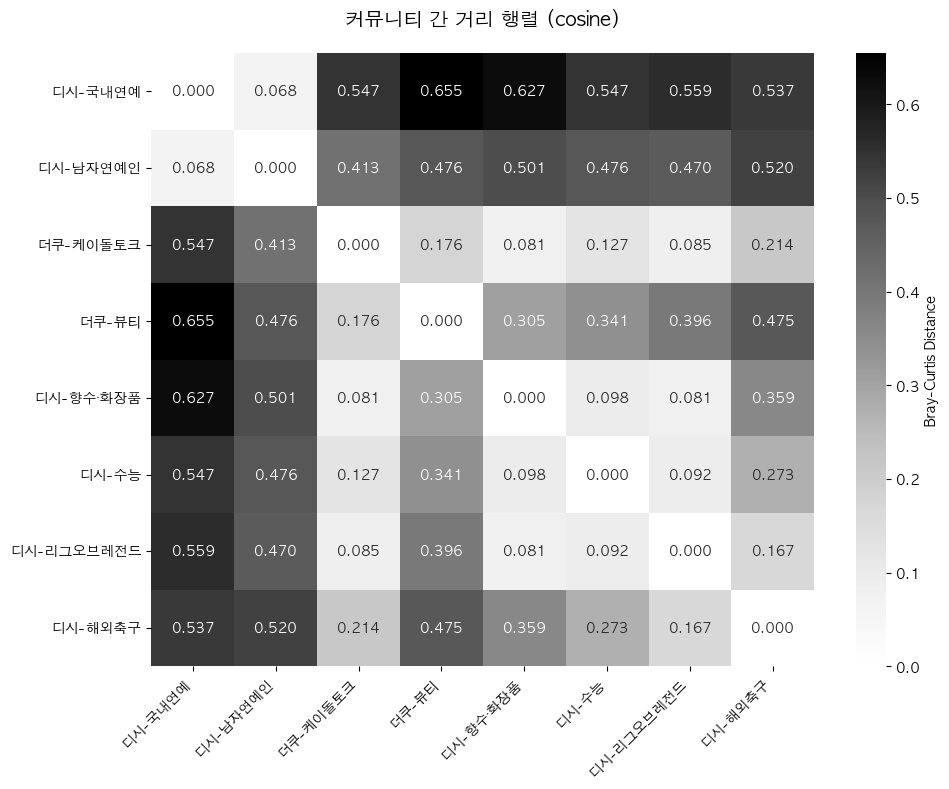

In [7]:
# 거리 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, fmt='.3f', 
            xticklabels=community_labels, yticklabels=community_labels,
            cmap='Greys', cbar_kws={'label': 'Bray-Curtis Distance'})
plt.title('커뮤니티 간 거리 행렬 (cosine)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(results_dir / 'distance_matrix.png', dpi=150)
plt.show()

## 3. MDS 수행

### 목적
커뮤니티를 2D 공간에 투영하여 "방언 지도"를 생성합니다.

### MDS란?
- Multidimensional Scaling (다차원척도법)
- 고차원 데이터를 2D/3D로 차원 축소
- 거리가 가까울수록 언어 패턴이 유사함

In [8]:
# MDS로 2D 좌표 계산
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

print("MDS coordinates:")
for i, comm in enumerate(community_labels):
    print(f"{comm}: ({coords[i, 0]:.4f}, {coords[i, 1]:.4f})")

MDS coordinates:
디시-국내연예: (0.3923, -0.1605)
디시-남자연예인: (0.3234, -0.0677)
더쿠-케이돌토크: (-0.0827, 0.0647)
더쿠-뷰티: (-0.0094, 0.2969)
디시-향수·화장품: (-0.1746, 0.0898)
디시-수능: (-0.1624, 0.0193)
디시-리그오브레전드: (-0.1470, -0.0347)
디시-해외축구: (-0.1397, -0.2079)


/Users/hyeonseokim_macbookpro/Desktop/서강대학교/2025/2025년 2학기/국어학연습 (김한별 교수님)/paper/code/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


### 방언 지도 시각화

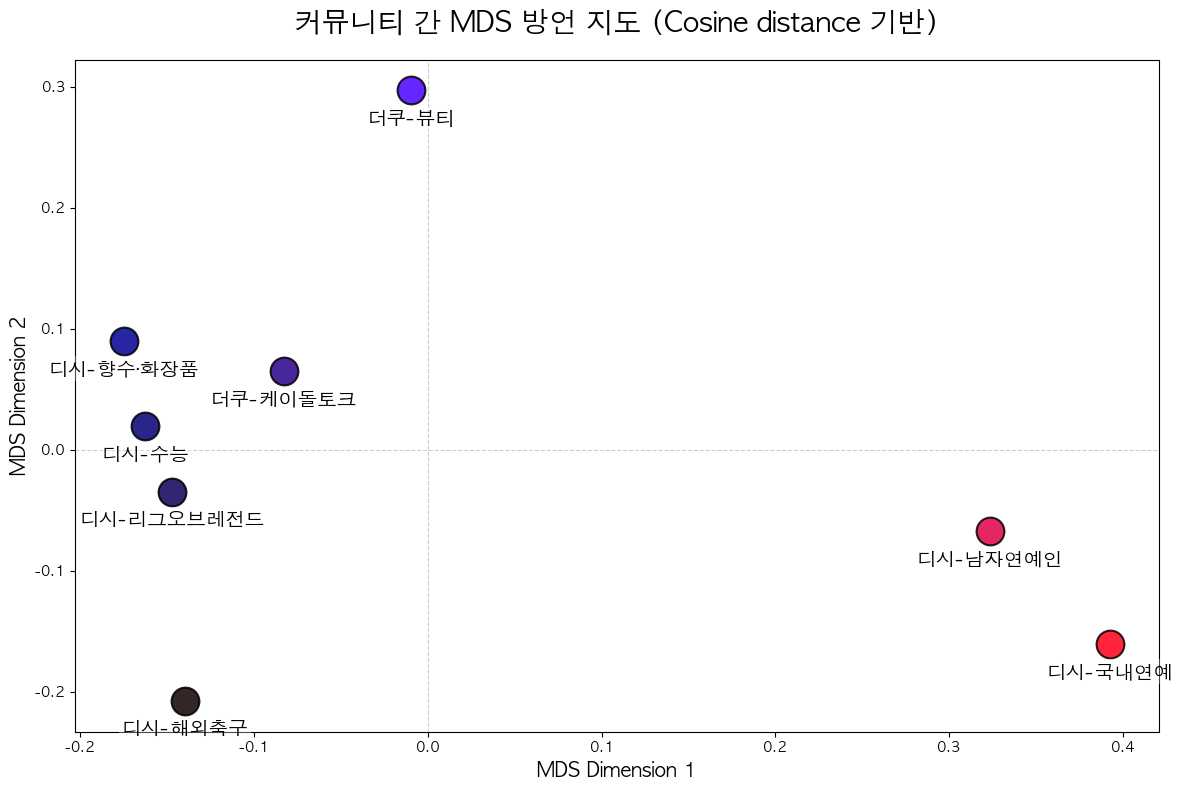

저장: ../data/results/mds_dialect_map_cosine.png


In [9]:
plt.figure(figsize=(12, 8))

# MDS 좌표
x = coords[:, 0]
y = coords[:, 1]

# 0~1 정규화 (RGB용)
x_norm = (x - x.min()) / (x.max() - x.min())
y_norm = (y - y.min()) / (y.max() - y.min())

# 색상 생성
# x → Red, y → Blue
colors = np.stack([
    x_norm,                  # R
    np.zeros_like(x_norm),   # G
    y_norm                   # B
], axis=1)

for i, comm in enumerate(community_labels):
    # 점
    plt.scatter(
        coords[i, 0],
        coords[i, 1],
        s=400,
        c=[colors[i]],
        alpha=0.85,
        edgecolors='black',
        linewidths=1.5,
        zorder=2
    )

    # 라벨 (점 위)
    plt.text(
        coords[i, 0],
        coords[i, 1] - 0.015,   # 👈 y축 방향 오프셋
        comm,
        fontsize=14,
        ha='center',
        va='top',
        zorder=3,
        bbox=dict(
            facecolor='white',
            alpha=0.3,
            edgecolor='none',
            pad=2
        )
    )

plt.xlabel('MDS Dimension 1', fontsize=14)
plt.ylabel('MDS Dimension 2', fontsize=14)
plt.title('커뮤니티 간 MDS 방언 지도 (Cosine distance 기반)', fontsize=20, pad=20)

# 중심선
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.4)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.4)

# 논문용: 눈금 제거
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.savefig(results_dir / 'mds_dialect_map_cosine.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / 'mds_dialect_map_cosine.png'}")


### 연결선 추가 (거리 기반)

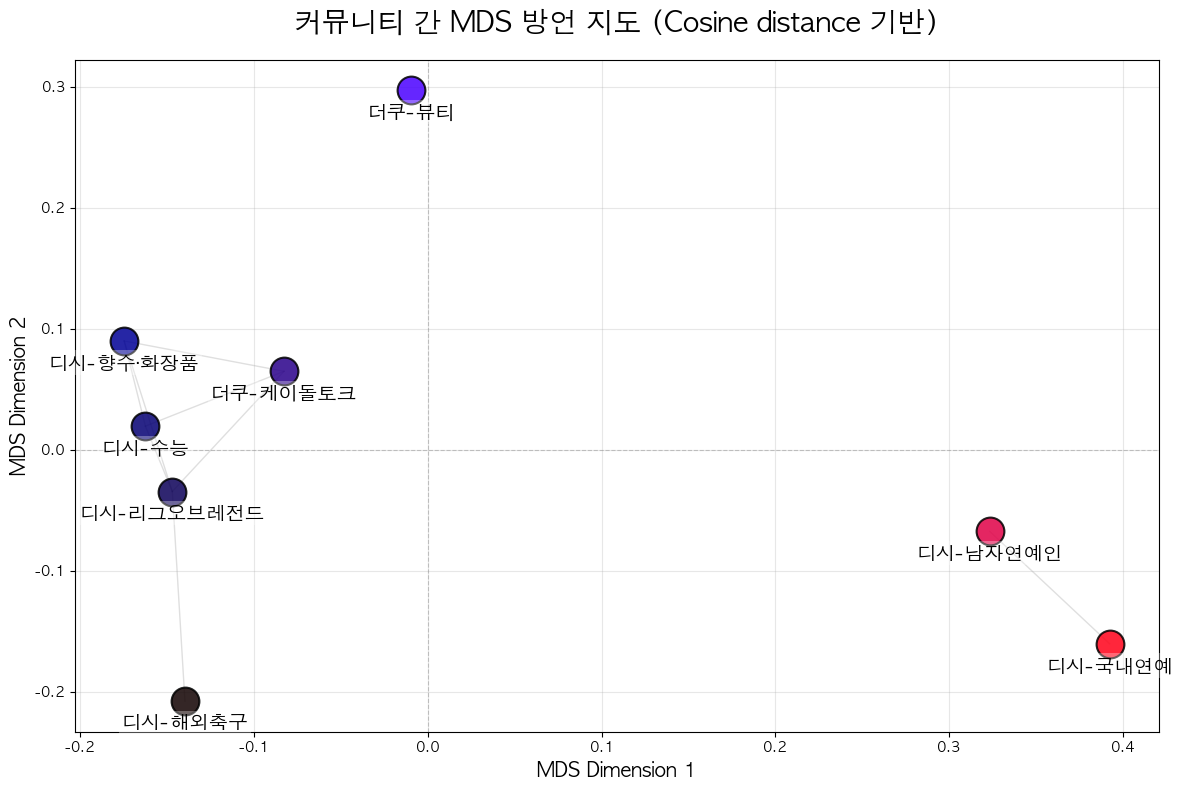

저장: ../data/results/mds_network_map_cosine-connections.png


In [10]:
plt.figure(figsize=(12, 8))

# MDS 좌표
x = coords[:, 0]
y = coords[:, 1]

# 0~1 정규화 (RGB용)
x_norm = (x - x.min()) / (x.max() - x.min())
y_norm = (y - y.min()) / (y.max() - y.min())

# 색상 생성: x → Red, y → Blue
colors = np.stack([
    x_norm,                  # R
    np.zeros_like(x_norm),   # G
    y_norm                   # B
], axis=1)

# --------------------------
# 가까운 커뮤니티끼리 연결선
# --------------------------
threshold = np.percentile(distance_matrix[distance_matrix > 0], 30)  # 하위 30%

for i in range(len(community_labels)):
    for j in range(i + 1, len(community_labels)):
        if distance_matrix[i, j] < threshold:
            plt.plot(
                [coords[i, 0], coords[j, 0]],
                [coords[i, 1], coords[j, 1]],
                color='gray',
                alpha=0.25,
                linewidth=1.0,
                zorder=1
            )

# --------------------------
# 포인트 + 라벨(아래)
# --------------------------
for i, comm in enumerate(community_labels):
    plt.scatter(
        coords[i, 0],
        coords[i, 1],
        s=400,
        c=[colors[i]],
        alpha=0.85,
        edgecolors='black',
        linewidths=1.5,
        zorder=2
    )

    plt.text(
        coords[i, 0],
        coords[i, 1] - 0.01,   # 라벨을 노드 아래로
        comm,
        fontsize=14,
        ha='center',
        va='top',
        zorder=3,
        bbox=dict(
            facecolor='white',
            alpha=0.3,
            edgecolor='none',
            pad=2
        )
    )

plt.xlabel('MDS Dimension 1', fontsize=14)
plt.ylabel('MDS Dimension 2', fontsize=14)
plt.title('커뮤니티 간 MDS 방언 지도 (Cosine distance 기반)', fontsize=20, pad=20)

plt.grid(True, alpha=0.3)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.4)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.4)

plt.tight_layout()
plt.savefig(results_dir / 'mds_network_map_cosine-connections.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / 'mds_network_map_cosine-connections.png'}")


## 4. 계층적 군집 분석 (Hierarchical Clustering)

### 목적
커뮤니티 간 언어적 친족도를 덴드로그램으로 표현합니다.

### 계층적 군집이란?
- 데이터를 계층적 트리 구조로 그룹화
- 덴드로그램으로 친족 관계 시각화

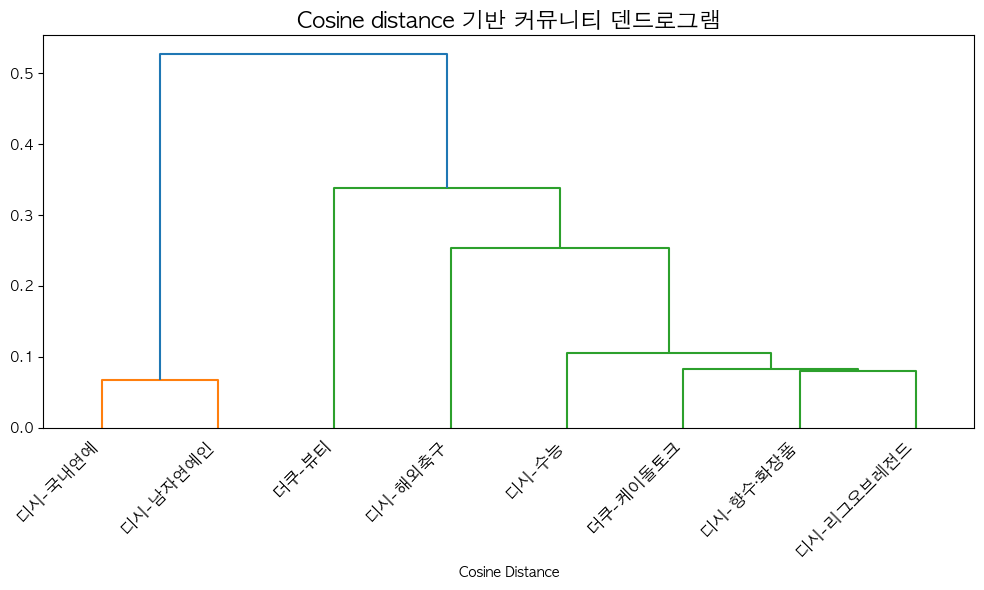

저장: ../data/results/dendrogram_cosine.png


In [11]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

condensed = squareform(distance_matrix)
linkage_matrix = hierarchy.linkage(condensed, method='average')

plt.figure(figsize=(10, 6))

hierarchy.dendrogram(
    linkage_matrix,
    labels=community_labels,
    orientation='top',
    leaf_font_size=12,
    color_threshold=0.7 * linkage_matrix[:, 2].max()
)

plt.xlabel('Cosine Distance')
plt.title('Cosine distance 기반 커뮤니티 덴드로그램', fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(results_dir / 'dendrogram_cosine.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / 'dendrogram_cosine.png'}")